In [1]:
import numpy as np
import P_Cyg as pc
import matplotlib.pyplot as plt
from glob import glob
from astropy.io import fits as fts
import pandas as pd
%matplotlib inline

In [2]:
#Getting lists of data files
datadir = 'C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Data/'
fits = glob(datadir + 'hpolccd*r_hw.fits')
txt = glob(datadir + 'hpolccd*r_hw.fits.txt')
blue_fits = glob(datadir + 'hpolccd*b_hw.fits')
blue_txt = glob(datadir + 'hpolccd*b_hw.fits.txt')
ret_txt = glob(datadir + "hpolret*.txt")
ret_fits = glob(datadir + "hpolret*.fits")
all_txt = glob(datadir+"*.txt")
all_fits = glob(datadir+"*.fits")
posterdir = "C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Figures/Poster/"

In [3]:
#Extracting wavelength, q, u, and error for all red ccd observations
ws,qs,us,es = [],[],[],[]
for f in txt:
    w,f,q,u,e = pc.txt_QU_data(f, 1000, radial_velocity=-8.9)
    ws.append(w)
    qs.append(q)
    us.append(u)
    es.append(e)

In [4]:
#Getting an average H alpha q, u and the inverse of the variance (1/e**2)
ave_qs,ave_us,variance = [],[],[]
#loop through each observation
for w,q,u,e,name in zip(ws,qs,us,es,all_txt):
    line_q,line_u,line_e = [],[],[]
    #in each observation, grab only the H alpha line
    for ww,qq,uu,ee in zip(w,q,u,e):
        if ww >= 6540 and ww <= 6600:
            line_q.append(qq)
            line_u.append(uu)
            line_e.append(ee)
    #store average across line for each observation
    ave_qs.append(np.mean(line_q))
    ave_us.append(np.mean(line_u))
    variance.append(1/(np.mean(line_e)**2))
ave_qs,ave_us,variance = np.array(ave_qs),np.array(ave_us),np.array(variance)

In [5]:
#Average Q - inversely weighted by the variance
topsum = sum(ave_qs*variance)
bottom = sum(variance)
average_q = (topsum/bottom)
print(average_q)

0.3748526214730818


In [6]:
#Average U - inversely weighted by the variance
topsum = sum(ave_qs*variance)
bottom = sum(variance)
average_q = (topsum/bottom)
print(average_q)
topsum = sum(ave_us*variance)
average_u = (topsum/bottom)
print(average_u)

0.3748526214730818
1.0219466948010434


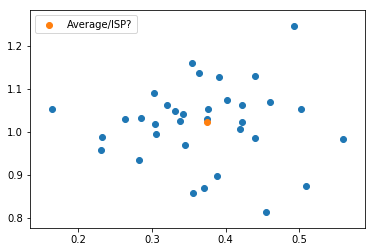

In [7]:
#Showing that these average values look like they're in the middle of our data
plt.scatter(ave_qs,ave_us)
plt.scatter(average_q,average_u,label='Average/ISP?')
plt.legend(loc='best')

In [8]:
ave_pol,ave_pos = pc.polarization(average_q,average_u)
print(ave_pol,ave_pos)

1.0885263133429612 34.92841779724296


In [9]:
#Finding Pmax in Serkowski Equation of ISP
exponential_term = np.exp(1.15*(np.log(5500/6563)**2))
Pmax = ave_pol*exponential_term
print(Pmax)

1.1283213377244479


In [10]:
#KeyanISP has a fixed max wavelength, but fits to our H alpha data
def KeyanISP(w):
    return(Pmax*np.exp(-1.15*(np.log(5500/np.array(w))**2)))
#NordISP is the ISP estimate from the original paper
def NordISP(wavelength):
    wavelength = np.array(wavelength)
    ISP = 1.06*np.exp(-1.15*(np.log(5500/wavelength)**2))
    return(ISP)

In [11]:
#get the medium of the wavelength data to plot our results against
mw,mf,mpol,mpos,me = pc.mean_flux_pol_pos(txt, fits, 1000, radial_velocity=-8.9)

(0.5, 1.5)

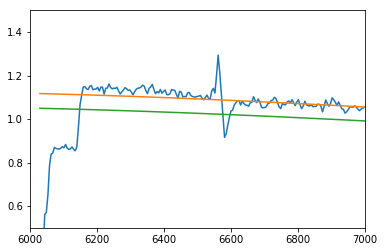

In [12]:
plt.plot(mw,mpol)
plt.plot(mw,KeyanISP(mw))
plt.plot(mw,NordISP(mw))
plt.xlim(6000,7000)
plt.ylim(0.5,1.5)

In [13]:
#adding blue data
bmw,bmf,bmpol,bmpos,bme = pc.mean_flux_pol_pos(blue_txt, blue_fits, 1000, radial_velocity=-8.9)

In [14]:
#adding WUPPE data
files= glob("C:/Users/Keyan/Desktop/Science/Data/P-Cygni/wuppe/*.fits")
all_w = []
all_q = []
all_u = []
all_e = []

for f in files:
    hdu = fts.open(f)
    tablehdu = hdu[1].header
    t = hdu[1].data
    ww = t["WAVELENGTH"][0]
    all_w.append(w)
    q = t["Q"][0]
    all_q.append(q)
    u = t["U"][0]
    all_u.append(u)
    e = t["ERROR"][0]
    all_e.append(e)
print(len(ww))
mq=np.mean(all_q,axis=0)
mu=np.mean(all_u,axis=0)

wmpol,wmpos = pc.polarization(mq,mu)

1024


In [15]:
retw,retf,retpol,retpos,rete= pc.mean_flux_pol_pos(ret_txt, ret_fits, 1000, radial_velocity=-8.9)

<ErrorbarContainer object of 3 artists>

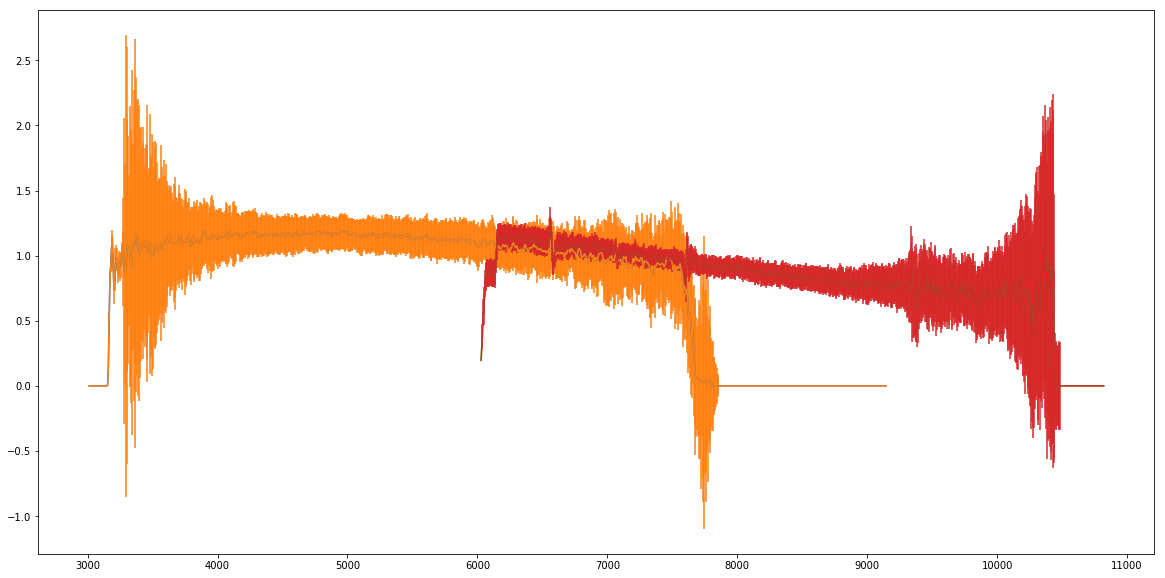

In [16]:
plt.figure(figsize=(20,10))
plt.plot(retw,retpol)
plt.errorbar(retw,retpol,yerr=rete)
plt.plot(mw,mpol)
plt.errorbar(mw,mpol,yerr=me)
#plt.xlim(6500,6650)

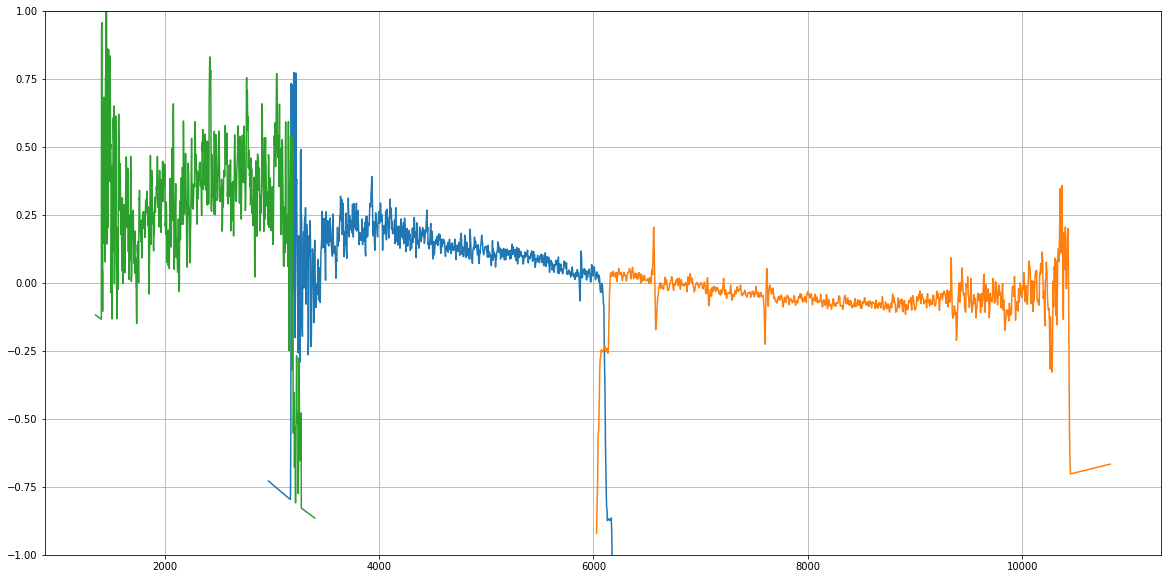

In [17]:
#Mean data with KeyanISP taken out, there is clearly some wavelength dependence still 
plt.figure(figsize=(20,10))
plt.ylim(-1,1)
plt.grid()
plt.plot(bmw,bmpol-KeyanISP(bmw))
plt.plot(mw,mpol-KeyanISP(mw))
plt.plot(ww,wmpol-KeyanISP(ww))



In [18]:
#get a combined mean polarization spectrum with blue and red hpol to fit ISP with
wavelength = []
polarization = []
"""for w,p in zip(ww,wmpol):
    if w >= 2000 and w <= 3000:
        wavelength.append(w)
        polarization.append(p)"""
for w,p in zip(bmw,bmpol):
    if w >= 4000 and w <= 6000:
        wavelength.append(w)
        polarization.append(p)
for w,p in zip(mw,mpol):
    if w >= 6200 and w <= 9000:
        wavelength.append(w)
        polarization.append(p)
"""for w,p in zip(retw,retpol):
    if w >= 6200 and w <= 9000:
        wavelength.append(w)
        polarization.append(p)"""        
wavelength = np.array(wavelength)
polarization = np.array(polarization)

In [19]:
#Finding best Pmax in Serkowski Equation of ISP
def ISP(lmax,pmax,w):
    return(pmax*np.exp(-1.15*(np.log(lmax/np.array(w))**2)))
best_wavelength = 0
best_error = 100000000
best_pmax = 0
for l in np.linspace(4000,6000,2001):    
    exponential_term = np.exp(1.15*(np.log(l/6563)**2))
    test_pmax = ave_pol*exponential_term
    test_ISP = np.array(ISP(l,test_pmax,wavelength))
    error = sum((polarization-test_ISP)**2)
    if error < best_error:
        best_wavelength = l
        best_error = error
        best_pmax = test_pmax
print(best_error,best_wavelength)  

0.8073063994189527 4688.0


In [20]:
#the max wavelength was related to the total to selective extinction ratio Rv, so if we change the max wavelength that can tell
#us something about Rv maybe? instead of 3.1 its in this range maybe?
low_Rv = 5.3*best_wavelength/10000
high_Rv = 5.9*best_wavelength/10000
print("Rv: "+str(low_Rv)+'-'+str(high_Rv))

Rv: 2.4846399999999997-2.76592


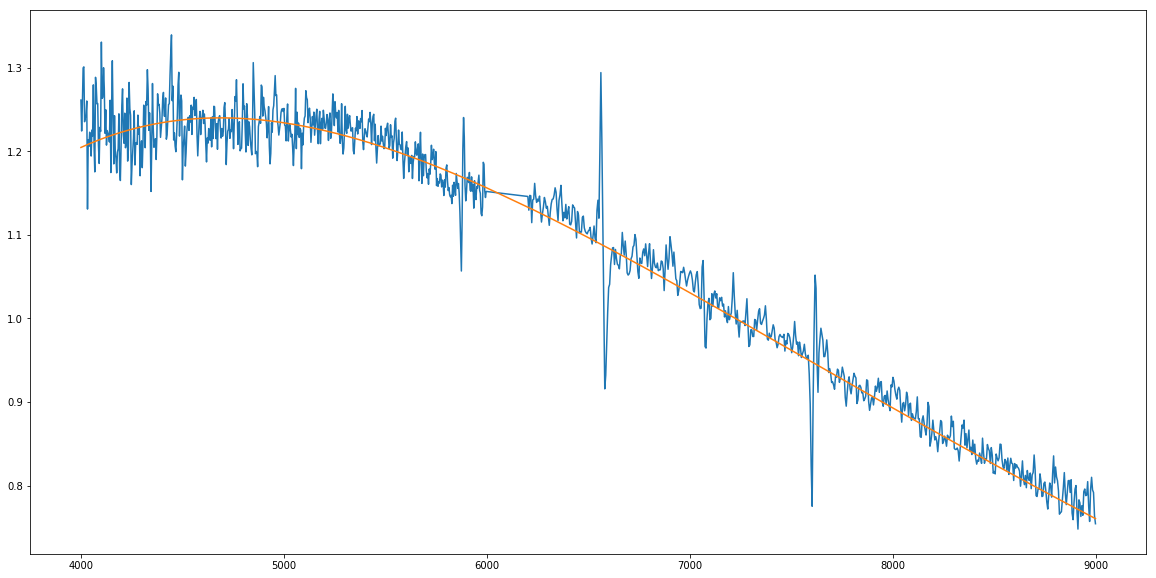

In [21]:
plt.figure(figsize=(20,10))
plt.plot(wavelength,polarization)
plt.plot(wavelength,ISP(best_wavelength,best_pmax,wavelength))
def BestISP(w):
    return(ISP(best_wavelength,best_pmax,w))

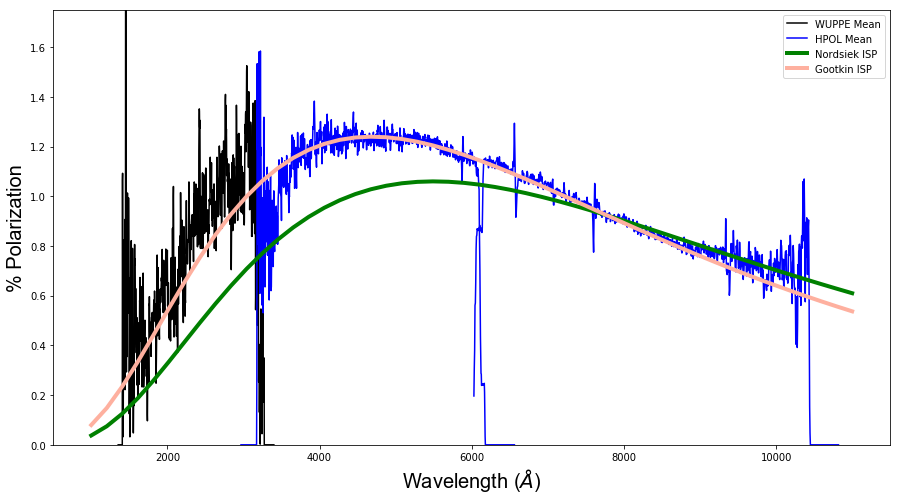

In [26]:
#A comparison of the fit of each ISP estimate
plt.figure(figsize=(15,8))
plt.ylim(0,1.75)
plt.plot(ww,wmpol,label="WUPPE Mean",color='black')
plt.plot(bmw,bmpol,label="HPOL Mean",color='b')
plt.plot(mw,mpol,color='b')
#plt.plot(retw,retpol,color="#aec6cf",label = "Reticon HPOL")
x = np.linspace(1000,11000)
#plt.plot(x,KeyanISP(x),label="Keyan ISP",color='r')
plt.plot(x,NordISP(x),label="Nordsiek ISP",color='green',lw=4)
plt.plot(x,BestISP(x),label="Gootkin ISP",color='#FEB09F',lw=4)
plt.legend(loc="best")
plt.xlabel(r"Wavelength ($\AA$)",fontname="Arial",fontsize=20)
plt.ylabel("% Polarization",fontname="Arial",fontsize=20)
plt.savefig(posterdir+"ISP_comparison.png",dpi=300,overwrite=True,transparent=True)

In [25]:
#a Function to extract q and u from % pol and position angle
def ISP_qu(ISP_pol,ISP_pa):
    q = np.array(ISP_pol)*np.cos(np.deg2rad(2*ISP_pa))
    u = np.array(ISP_pol)*np.sin(np.deg2rad(2*ISP_pa))
    return(q,u)

In [26]:
pol,pa = pc.polarization(average_q,average_u)
iq,iu = [],[]
for ww,qq,uu in zip(ws,qs,us):
    ispq,ispu = ISP_qu(BestISP(ww),pa)
    iq.append(np.array(qq)-np.array(ispq))
    iu.append(np.array(uu)-np.array(ispu))
ipol,ipos = pc.polarization(iq,iu)

(-0.4, 0.4)

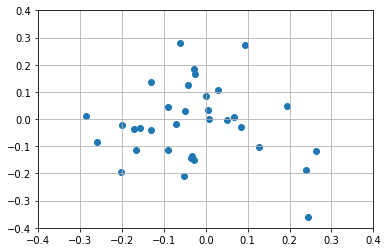

In [27]:
plt.scatter(np.mean(iq,axis=1),np.mean(iu,axis=1))
plt.grid()
plt.xlim(-0.4,0.4)
plt.ylim(-0.4,0.4)

In [28]:
miq,miu = np.mean(iq,axis=0),np.mean(iu,axis=0)
mipol,mipos = pc.polarization(miq,miu)

(6000, 7000)

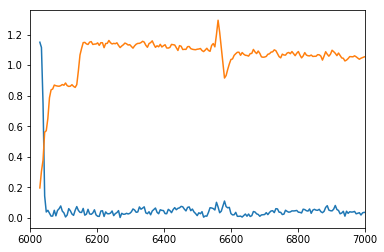

In [34]:
plt.plot(ws[0],mipol)
plt.plot(ws[0],mpol)
plt.xlim(6000,7000)

In [44]:
important = 19910930
for name in all_txt:
    w,f,q,u,e = pc.txt_QU_data(name, 1000, radial_velocity=-8.9)
    IspQ,IspU = ISP_qu(BestISP(w),pa)
    q = np.array(q)-np.array(IspQ)
    u = np.array(u)-np.array(IspU)
    pol,pos = pc.polarization(q,u)
    df = pd.DataFrame({"Wavelength":w , "Flux":f, "% Polarization":pol , "Position Angle":pos , "Error":e})
    df.to_csv(datadir+"intrinsic_pols/corrected"+name[49:],index=False,sep=":")